<a href="https://colab.research.google.com/github/fjorge000/Proyectos_ML/blob/Hotel_Predict/Proyecto_Final_Jorge_Sanchez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Reservación de Hoteles**

## **1. Introducción**

Los datos de las reservaciones de los hoteles nos permiten tener un panorama sobre las necesidades de los huéspedes, también se puede conocer cuál es el comportamiento general de las reservaciones que aunque la respuesta es muy trivial, se puede tomar como referencia para probar cada método que se desea emplear. Por otro lado, la información también nos ayudará a entender cómo es que se comportan las cancelaciones y saber en qué tipo de reservaciones se observa este comportamiento.

A partir de la información obtenida de 2015 a 2017 en la plataforma Kaggle a cerca de la reservación de 2 hoteles (Un City Hotel y un Resort Hotel) tenemos 31 variables que se irán filtrando y analizando para enfocar la información a lo que realmente deseamos conocer y proyectar.


>¿Cuál es el comportamiento general de las reservaciones basadas en esta información? 

>¿Es posible entender un comportamiento en las cancelaciones? 

>¿Existe alguna temporada o clasificación que permita entender este comportamiento?

Apoyándonos en las técnicas de minería de datos, ¿es posible encontrar un modelo que permita saber si un huésped va a cancelar o no?


## **2. Estado del Arte**

Dentro de la misma plataforma se realizó un análisis sobre reviews de hoteles ubicados en Estados Unidos, y se encontró un trabajo donde se clasifican estas reviews (no enfocado al Machine Learning) que permite obtener análisis estadísticos sobre estas reviews. [1]

Adicionalmente se toma como referencia un análisis de fraudes en tarjetas de crédito, aunque no está directamente relacionado con este proyecto, se toman los conocimientos y metodologías de este análisis pues responde a una pregunta con un enfoque muy similar a las propuestas en este escrito: ¿Cómo saber si una transacción es un pago normal o un fraude? Este proyecto utiliza varios clasificadores para saber cuál es el de mayor exactitud (accuracy) a partir de una red neuronal. [2]

[1] Primer análisis de información sobre reviews de hoteles: https://www.kaggle.com/kamparia/hotel-reviews-data

[2] Analisis de Fraude en tarjetas de crédito: https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets


## **3. Metodología**

### **3.1 Análisis Exploratorio de Datos**

Es importante siempre entender los datos que estamos analizando, por lo que se mostrará un analisis general de la información obtenida.

Observamos que existen 2 tipos de Hoteles (Resort Hotels & city Hotels) y existe una diferencia entre el numero de reservaciones que tenemos en ambos casos

Por otro lado, graficamos de forma sencilla el numero de reservaciones canceladas que se tienen como acumulado

In [ ]:
#### Load Libraries

import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from google.colab import drive, files

In [ ]:
#Cargando Sklearns para los algoritmos de ML

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, auc
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier

In [ ]:

drive.mount('/content/gdrive/')

data_h = pd.read_csv("/content/gdrive/My Drive/Diplomado/Modulo IV/Proyecto/hotel_bookings.csv",encoding = "ISO-8859-1")


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:

data_h.head(5)


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


Text(0, 0.5, 'Count')

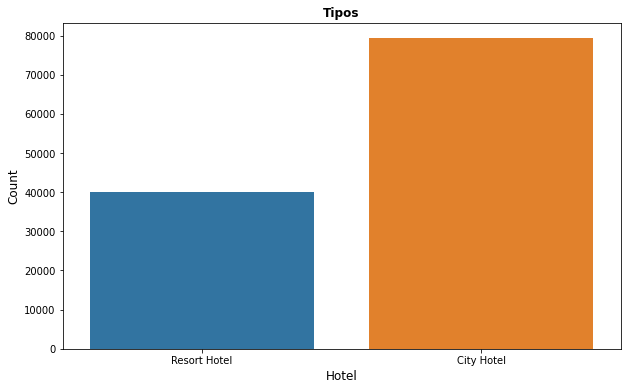

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(x='hotel', data=data_h)
plt.title('Tipos', weight='bold')
plt.xlabel('Hotel', fontsize=12)
plt.ylabel('Count', fontsize=12)

Text(0, 0.5, 'Count')

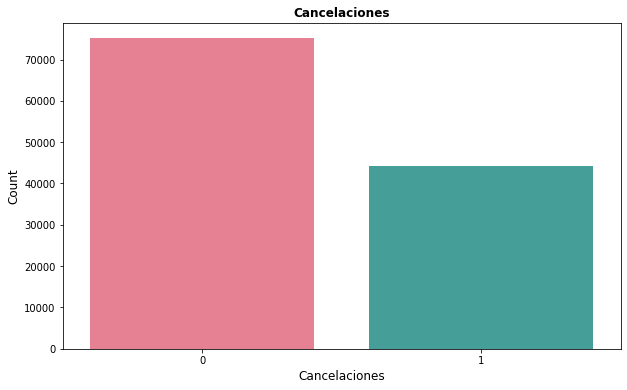

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(x='is_canceled', data=data_h,palette='husl')
plt.title('Cancelaciones', weight='bold')
plt.xlabel('Cancelaciones', fontsize=12)
plt.ylabel('Count', fontsize=12)

De igual modo, graficamos la tendencia de las reservaciones a lo largo de todos lo meses.

En la segunda grafica podemos observar de la misma forma las reservaciones canceladas (1) y no canceladas (0).

In [ ]:
# Selección y Agrupacion de los datos
temp_trend = data_h[['arrival_date_year','arrival_date_month','is_canceled','hotel']]
temp_trend['Arrival_Date'] = temp_trend.arrival_date_month.map(str) + "-" + temp_trend.arrival_date_year.map(str)

temp_trend['Arrival_Date'] = pd.to_datetime(temp_trend['Arrival_Date'],format='%B-%Y')
# Obtiene por mes
temp_trend['period'] = temp_trend['Arrival_Date'].dt.to_period('M')
temp_trend = temp_trend[['period','is_canceled','hotel']].groupby(['period','is_canceled']).count().reset_index()
temp_trend = temp_trend.sort_values('period')
temp_trend['period'] = temp_trend['period'].astype(str)

In [ ]:
plot1 = px.line(temp_trend,x='period',y='hotel',color='is_canceled',color_discrete_sequence =['#0277bd','#29434e'])
plot1.show()

Agrupamos solo las reservaciones concretadas para entender un poco más las temporadas en las que se reserva con mayor frecuencia


In [ ]:
temp_seas = data_h[data_h.is_canceled==0]
temp_seas = temp_seas[['arrival_date_month','hotel','lead_time']]
temp_seas['Month'] = pd.to_datetime(temp_seas['arrival_date_month'],format='%B')
aux = pd.DataFrame({'Month': list(temp_seas.arrival_date_month.unique()),'Indice': [7,8,9,10,11,12,1,2,3,4,5,6]}).sort_values('Indice')
temp_seas = temp_seas[['Month','hotel','lead_time']].groupby(['Month','hotel']).count().reset_index()
temp_seas['Indice']=temp_seas.Month.dt.month
temp_seas['Bookings'] = temp_seas.lead_time
temp_seas = temp_seas[['hotel','Indice','Bookings']]
temp_seas = pd.merge(temp_seas,aux,on='Indice',how='left')
temp_seas

plot1 = px.bar(temp_seas,x="Month",y="Bookings",color='hotel',barmode='group',color_discrete_sequence =['#0277bd','#29434e'])
plot1.show()


Observamos un ligero incremento en las reservaciones en Julio y Agosto, tanto para el City Hotel como para el Resort Hotel

Adicionalmente es importante conocer el numero de noches que los huespedes reservan. Observamos que la mayor cantidad de reservaciones se conentran entre las 1 y 5 noches, aunque en el city hotel tiene un crecimiento en 7 dias.



In [ ]:
## Agrupación para calcular el numero de reservaciones confirmadas por noche

temp_resn = data_h[data_h.is_canceled==0]
temp_resn = temp_resn[['stays_in_weekend_nights','stays_in_week_nights','hotel','arrival_date_week_number']]
temp_resn = temp_resn.assign(Nigths = lambda df: temp_resn.stays_in_week_nights + temp_resn.stays_in_weekend_nights)
temp_resn = temp_resn[['Nigths','hotel','arrival_date_week_number']].groupby(['Nigths','hotel']).count().reset_index()
temp_resn['Bookings'] = temp_resn.arrival_date_week_number
temp_resn = temp_resn[temp_resn['Bookings']>1]
temp_resn_1 = temp_resn[temp_resn.hotel=='City Hotel']
temp_resn_2 = temp_resn[temp_resn.hotel=='Resort Hotel']

In [ ]:
## Grafica del numero de reservaciones confirmadas por noche

fig = make_subplots(rows=1,cols=2, subplot_titles=('City Hotel','Resort Hotel'))

fig.add_trace(
  go.Bar(x=temp_resn_1.Nigths,y=temp_resn_1.Bookings),row=1,col=1
)
fig.add_trace(
  go.Bar(x=temp_resn_2.Nigths,y=temp_resn_2.Bookings),row=1,col=2
)
fig.update_layout(height=500, width=1000, title_text="Noches Reservadas por Tipo de Hotel",showlegend=False)
fig.update_xaxes(title_text="Noches")
fig.update_yaxes(title_text="Reservaciones")
fig.show()

Por otro lado, debemos conocer tambien la cantidad de personas que viajan solos o con más personas (Pareja o Familiar) para entender si **graficamente**  si existe alguna relación entre estas variables



In [ ]:
### Calcula el numero de resevarciones con respecto a la cantidad de personas que viajan

temp_per = data_h[['hotel','is_canceled','adults','children','babies']]
temp_per['Person'] = np.where((temp_per['adults'] == 1) & (temp_per['children'] < 1) & (temp_per['babies'] < 1),'Alone',np.where((temp_per['adults'] == 2) & (temp_per['children'] < 1) & (temp_per['babies'] < 1),'Pair','Familiar'))
temp_per = temp_per[['hotel','Person','is_canceled','adults']].groupby(['hotel','Person','is_canceled']).count().reset_index()
temp_per['Bookings'] = temp_per.adults
temp_per_1 = temp_per[temp_per.hotel=='City Hotel']
temp_per_2 = temp_per[temp_per.hotel=='Resort Hotel']

In [ ]:
### Grafica del numero de resevarciones con respecto a la cantidad de personas que viajan

fig = make_subplots(rows=1,cols=2, subplot_titles=('City Hotel','Resort Hotel'))

### Grafica City Hotel
fig.add_trace(
  go.Bar(x=temp_per_1.Person,y=temp_per_1.Bookings,marker=dict(color=['#0277bd','#29434e','#0277bd','#29434e','#0277bd','#29434e'])),row=1,col=1
)

### Grafica Resort Hotel
fig.add_trace(
  go.Bar(x=temp_per_2.Person,y=temp_per_2.Bookings,marker=dict(color=['#0277bd','#29434e','#0277bd','#29434e','#0277bd','#29434e'])),row=1,col=2
)
fig.update_layout(height=500, width=1000, title_text="Noches Reservadas por Tipo de Hotel",showlegend=False)
fig.update_xaxes(title_text="Tipo de reservacion")
fig.update_yaxes(title_text="Reservaciones")
fig.show()

Como podemos observar, el numero de cancelaciones es menor en los Resort Hotel, asi mismo, la mayor cantidad de reservaciones canceladas son para personas que viajan en Pareja y los que presentan un porcentaje menor son las reservaciones de una sola persona en Resort Hotels.

Adicionalmente, es importante conocer las correlación que presentan las diferentes variables.


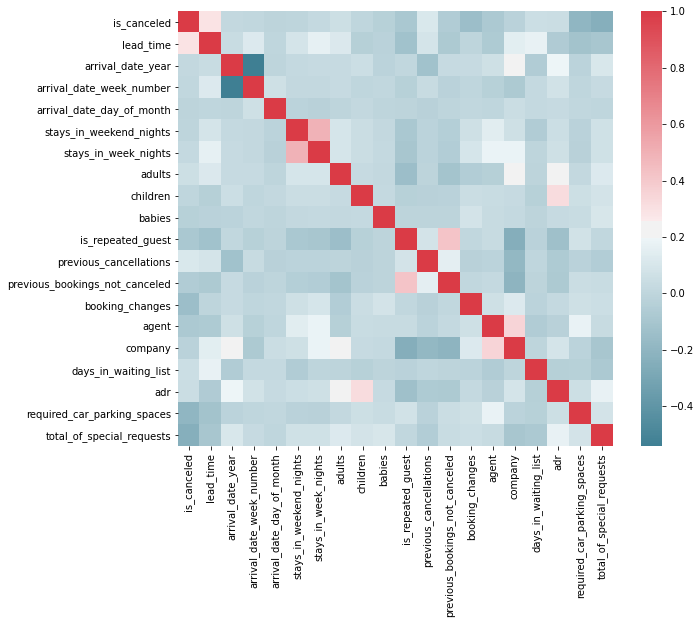

In [ ]:
## Obtiene la correlación de las diferentes variables de nuestra información

f, ax = plt.subplots(figsize=(10, 8))
corr = data_h.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

Observamos que al ser variables categorícas, la correlación de la mayoría son bajas, excepto dos, pues directamente son valores que permiten saber si puede ser cancelada o no una reservación, por lo que se decide agrupar la información para tener un mejor panorama de la correlación.

1.   **is_canceled** 
2.   **lead_time**



In [ ]:
# Selección de estas variables y agrupación de datos

data_corr = data_h[['is_canceled','lead_time','arrival_date_year']]
data_corr = data_corr.groupby(['lead_time','is_canceled']).count().reset_index()
data_corr['Bookings'] = data_corr.arrival_date_year
data_corr = data_corr[['lead_time','is_canceled','Bookings']]
data_aux = data_h[['lead_time','arrival_date_year']].groupby('lead_time').count().reset_index()
data_aux['totalBooks'] = data_aux.arrival_date_year
data_aux = data_aux[['lead_time','totalBooks']]
data_corr = pd.merge(data_corr,data_aux,on='lead_time',how='left')
data_corr = data_corr.assign(Percentaje = lambda df : round(data_corr.Bookings/data_corr.totalBooks*100,2))
data_corr_0 = data_corr[data_corr['is_canceled']==0]
data_corr_1 = data_corr[data_corr['is_canceled']==1]



In [ ]:
fig = go.Figure()

### Grafica Cancelas
fig.add_trace(
  go.Scatter(x=data_corr_0.lead_time,y=data_corr_0.Percentaje,mode='markers'
  ,marker_color='#0277bd',name='No Canceladas')
)

### Grafica No Canceladas
fig.add_trace(
  go.Scatter(x=data_corr_1.lead_time,y=data_corr_1.Percentaje,mode='markers'
  ,marker_color='#29434e',name='Canceladas')
)
fig.update_layout(height=800, width=800, title_text="Reservaciones por tiempos de Espera")
fig.update_xaxes(title_text="Tiempo de Espera")
fig.update_yaxes(title_text="Porcentaje de Reservaciones")
fig.show()

Observamos que al llevar a porcentajes nuestra información de cancelaciones de las reservación con respecto al Tiempo de espera, nuestra correlación incrementa, es decir, mientras mayor es el tiempo de esperam mayor es el porcentaje de las cancelaciones.

Por otro lado, tambien analizamos otra de las variables para entender si tenemos cierta correlación vs las cancelaciones.



In [ ]:
## Calcula las cancelaciones por noche reservada en porcentaje

temp_npc = data_h[['stays_in_weekend_nights','stays_in_week_nights','hotel','is_canceled']]
temp_npc = temp_npc.assign(Nigths = lambda df: temp_npc.stays_in_week_nights + temp_npc.stays_in_weekend_nights)
temp_npc = temp_npc[['Nigths','is_canceled','hotel']].groupby(['Nigths','is_canceled']).count().reset_index()
data_aux = temp_npc[['Nigths','hotel']].groupby('Nigths').sum().reset_index()
data_aux['totalBooks'] = data_aux.hotel
data_aux = data_aux[['Nigths','totalBooks']]  
temp_npc = pd.merge(temp_npc,data_aux,on='Nigths',how='left')
temp_npc = temp_npc.assign(Percentaje = lambda df : round(temp_npc.hotel/temp_npc.totalBooks*100,2))
#temp_npc_0 = temp_npc[temp_npc['is_canceled']==0]
temp_npc_1 = temp_npc[temp_npc['is_canceled']==1]

In [ ]:
fig = go.Figure()

### Grafica Canceladas Por noche
fig.add_trace(
  go.Scatter(x=temp_npc_1.Nigths,y=temp_npc_1.Percentaje,mode='markers'
  ,marker_color='#0277bd')
)

fig.update_layout(height=600, width=600, title_text="Cancelaciones por Noche reservada")
fig.update_xaxes(title_text="Noches")
fig.update_yaxes(title_text="Porcentaje de Reservaciones")
fig.show()

Observamos que por cada noche reservada, la tendencia a ser cancelda es mayor, sin embargo hay que considerar que son porcentajes.



### **3.2 Prepacación de los Datos**

Es importate saber cuales son las variables a considerar ademas de tambien quitar aquellos valores que consideramos atipicos o perdidos (Missing Values). Por lo que en este apartado realizaremos una exploración de nuestra data para saber si cualquier variable puede ser considerada para nuestro modelo.



In [ ]:
## Preparación de la información
#Definimos funcion para retornar los valores ausentes (Null) y la información

data_ml = data_h

def missing_info(data_mi):
  data_miss = pd.DataFrame(data_mi.isnull().sum()).reset_index()
  data_miss.columns = ['Variable','IsNull']
  data_miss = data_miss[data_miss['IsNull']>0]  

  return data_miss 

data_miss = missing_info(data_ml)
data_miss.head()

,Variable,IsNull
10,children,4
13,country,488
23,agent,16340
24,company,112593


In [ ]:

info_data = pd.DataFrame(data_ml.info()).reset_index()
info_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

,index


Gracias a las investigaciones anteriores sobre esta información, el numero de columnas con caracteres perdidos es minima e incluso no todas estas columnas no se utilizarán para el modelado de la casificacion y de la predicción.

Sustituimos los valores nulos por *ceros* en el caso de *children* y con *'UNCOU'* para la columna *Country*

In [ ]:
data_ml['children'] = data_ml['children'].fillna(0)
data_ml['country'] = data_ml['country'].fillna('UNCOU')  #Pais Desconocido
missing_info(data_ml)


,Variable,IsNull
23,agent,16340
24,company,112593


Para la columna children y babies utilizaremos un totalizador, pues para esta propuesta regularmente se consideran un solo conjunto (Niños + Bebes). Realizamos lo mismo para el total de noches.

Por otro lado tambien eliminamos las dos columnas anteriores en las cuales presentamos valores ausentes en un gran porcentaje de las observaciones

In [ ]:
data_ml = data_ml.assign(Nigths = lambda df: data_ml.stays_in_week_nights + data_ml.stays_in_weekend_nights)
data_ml = data_ml.assign(TotChildren = lambda df :data_ml.children + data_ml.babies)


#Eliminamos las columnas con las que realizamos las operaciones:
delete_columns = ['children','babies','stays_in_weekend_nights','stays_in_week_nights','agent','company']
data_ml = data_ml.drop(delete_columns,axis=1)
data_ml.head(7)


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,adults,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,Nigths,TotChildren
0,Resort Hotel,0,342,2015,July,27,1,2,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,0,Transient,0.0,0,0,Check-Out,2015-07-01,0,0.0
1,Resort Hotel,0,737,2015,July,27,1,2,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,0,Transient,0.0,0,0,Check-Out,2015-07-01,0,0.0
2,Resort Hotel,0,7,2015,July,27,1,1,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,0,Transient,75.0,0,0,Check-Out,2015-07-02,1,0.0
3,Resort Hotel,0,13,2015,July,27,1,1,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,0,Transient,75.0,0,0,Check-Out,2015-07-02,1,0.0
4,Resort Hotel,0,14,2015,July,27,1,2,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,0,Transient,98.0,0,1,Check-Out,2015-07-03,2,0.0
5,Resort Hotel,0,14,2015,July,27,1,2,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,0,Transient,98.0,0,1,Check-Out,2015-07-03,2,0.0
6,Resort Hotel,0,0,2015,July,27,1,2,BB,PRT,Direct,Direct,0,0,0,C,C,0,No Deposit,0,Transient,107.0,0,0,Check-Out,2015-07-03,2,0.0


Para el modelo es importante que nuestras variables del tipo caracter (Object) sean tomadas como valores numericos, por lo que realizamos un Encoder para llevar a cabo esta transformación de datos.
